In [11]:
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random
import glob
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential

In [16]:
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
from pathlib import Path

In [45]:
extractall_path = "./data"
zf.ZipFile('./data/trash_kaggle.zip').extractall(extractall_path)



os.listdir(extractall_path)



['.ipynb_checkpoints',
 'trash_kaggle.zip',
 '__MACOSX',
 'train',
 'valid',
 'trash_kaggle',
 'test']

In [49]:
train_data = ImageDataGenerator(rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
validation_split=0.2)

test_data = ImageDataGenerator(rescale=1./255,
validation_split=0.1)

training_set = train_data.flow_from_directory('./data/trash_kaggle',target_size=(300,300),
batch_size=16,class_mode='categorical',subset='training',seed=0)


validation_set = test_data.flow_from_directory('./data/trash_kaggle',target_size=(300,300),
batch_size=16,class_mode='categorical',subset='validation',seed=0)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)


Found 2024 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [6]:
files = zf.ZipFile("./data/trash_kaggle.zip",'r')
files.extractall()
files.close()

In [7]:
os.listdir(os.path.join(os.getcwd(),"trash_kaggle"))

['cardboard', 'glass', 'trash', 'paper', 'metal', 'plastic', '.DS_Store']

In [18]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [20]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('trash_kaggle',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [21]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path


PosixPath('/home/lab02/data')

In [25]:
train_data = ImageDataGenerator(rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
validation_split=0.7)

test_data = ImageDataGenerator(rescale=1./255,
validation_split=0.1)

training_set = train_data.flow_from_directory('./data/train',target_size=(300,300),
batch_size=32,class_mode='categorical',subset='training',seed=0)

validation_set = test_data.flow_from_directory('./data/valid',target_size=(300,300),
batch_size=32,class_mode='categorical',subset='validation',seed=0)

Found 382 images belonging to 6 classes.
Found 61 images belonging to 6 classes.


In [50]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [51]:
history = model.fit(training_set, epochs=15, validation_data=validation_set)

Epoch 1/15
127/127 [==============================] - 134s 1s/step - loss: 1.7362 - acc: 0.2348 - val_loss: 1.6610 - val_acc: 0.2590
Epoch 2/15
127/127 [==============================] - 134s 1s/step - loss: 1.5016 - acc: 0.3664 - val_loss: 1.4668 - val_acc: 0.3705
Epoch 3/15
127/127 [==============================] - 135s 1s/step - loss: 1.3021 - acc: 0.4639 - val_loss: 1.3175 - val_acc: 0.4781
Epoch 4/15
127/127 [==============================] - 135s 1s/step - loss: 1.2477 - acc: 0.5028 - val_loss: 1.3018 - val_acc: 0.5060
Epoch 5/15
127/127 [==============================] - 133s 1s/step - loss: 1.0996 - acc: 0.5744 - val_loss: 1.2159 - val_acc: 0.5060
Epoch 6/15
127/127 [==============================] - 134s 1s/step - loss: 0.9400 - acc: 0.6625 - val_loss: 1.3342 - val_acc: 0.5060
Epoch 7/15
127/127 [==============================] - 134s 1s/step - loss: 0.9733 - acc: 0.6456 - val_loss: 1.1413 - val_acc: 0.5697
Epoch 8/15
127/127 [==============================] - 133s 1s/step - 

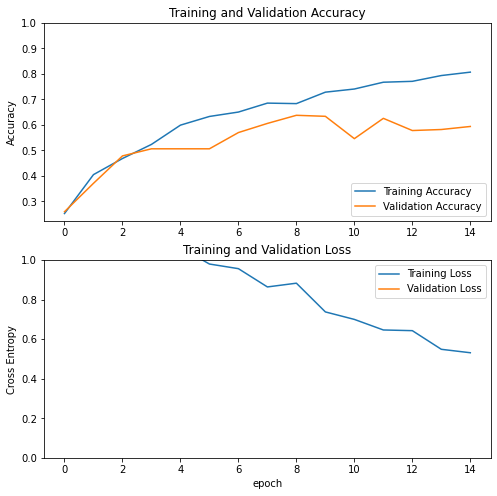

In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 32)       

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


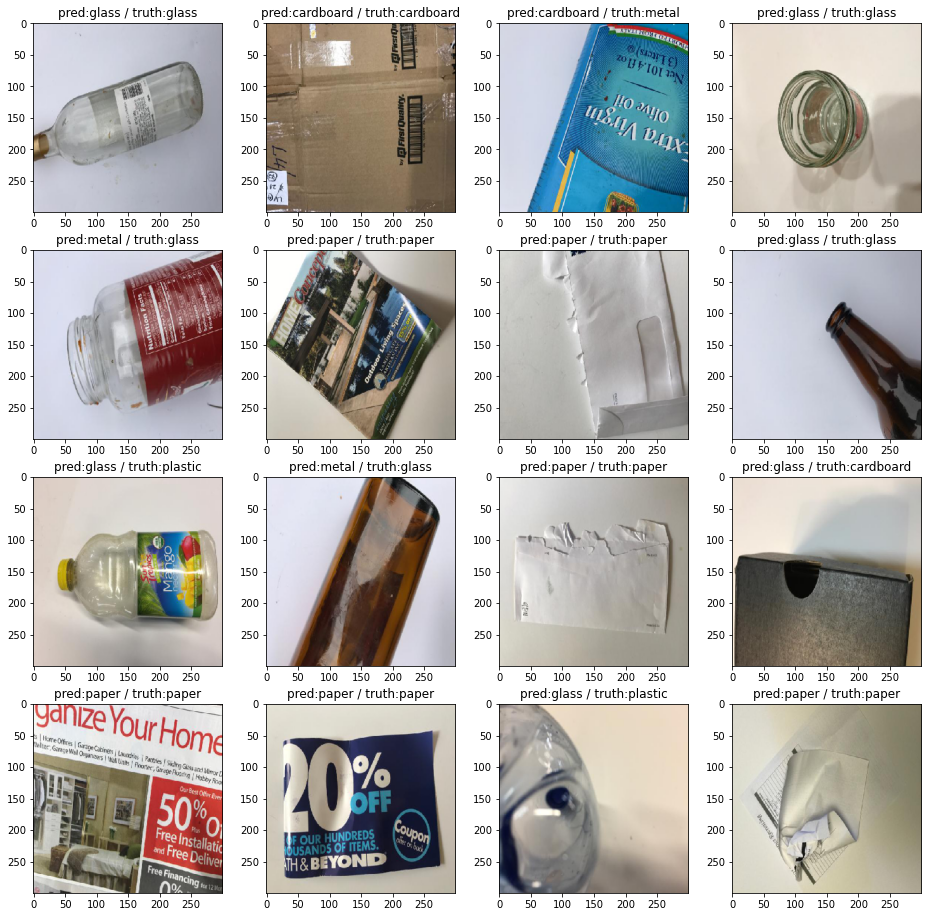

In [64]:
test_x, test_y = validation_set.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [60]:
from keras.applications import ResNet50
import tensorflow as tf

In [61]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


net = build_model(num_classes=6)

net.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [62]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = net.fit(
    generator=training_set,
    validation_data=validation_set,
    epochs=30,
    validation_freq=1,
    callbacks=[early_stop]
)

/home/ubuntu/anaconda3/envs/yejiEnv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
127/127 [==============================] - 444s 3s/step - loss: 2.1071 - categorical_accuracy: 0.2078 - val_loss: 1.6473 - val_categorical_accuracy: 0.2351
Epoch 2/30
127/127 [==============================] - 439s 3s/step - loss: 1.7209 - categorical_accuracy: 0.2575 - val_loss: 1.7190 - val_categorical_accuracy: 0.2351
Epoch 3/30
127/127 [==============================] - 438s 3s/step - loss: 1.6827 - categorical_accuracy: 0.2630 - val_loss: 1.6388 - val_categorical_accuracy: 0.2430
Epoch 4/30
127/127 [==============================] - 446s 4s/step - loss: 1.6347 - categorical_accuracy: 0.2660 - val_loss: 1.6346 - val_categorical_accuracy: 0.2590
Epoch 5/30
127/127 [==============================] - 438s 3s/step - loss: 1.6295 - categorical_accuracy: 0.2697 - val_loss: 1.6055 - val_categorical_accuracy: 0.3187
Epoch 6/30
127/127 [==============================] - 441s 3s/step - loss: 1.6524 - categorical_accuracy: 0.3079 - val_loss: 1.6021 - val_categorical_accuracy: 0.294